In [ ]:
# Import required packages
using DrWatson
@quickactivate "APLG"
include(srcdir("pdes.jl"))
include(srcdir("sims.jl"))
include(srcdir("travelling.jl"))
include(srcdir("plotting.jl"))

In [2]:
# Create parameters
params = []
ϕas = [0.5, 0.3]
ϕps = [0.1, 0.6]
DT, v0, DR, N, Δx, Lx, Ly = 1.0, 20.0, 1.0, 100, 0.01, 2.0, 0.5
δt, δ = 1e-5, 0.1  # Time step parameters
T, save_interval, param_name = 20.0, 0.01, "figs_2-3"

# Generate parameters for each configuration
map(ϕas, ϕps) do ϕa, ϕp
    param = new_param(DT, v0, DR, N, Δx, Lx, Ly, ϕa, ϕp, δt, δ; 
                     T = T, name = param_name, save_interval = save_interval, save_on = true)
    push!(params, param)
end

2-element Vector{Vector{Any}}:
 [Dict{String, Any}("T" => 20.0, "save_interval" => 0.01, "δ" => 0.1, "δt" => 1.0e-5, "name" => "figs_2-3", "save_on" => true, "DT" => 1.0, "Lx" => 2.0, "N" => 100, "DR" => 1.0…), Dict{String, Any}("T" => 20.0, "save_interval" => 0.01, "δ" => 0.1, "δt" => 1.0e-5, "name" => "figs_2-3", "save_on" => true, "DT" => 1.0, "Lx" => 2.0, "N" => 100, "DR" => 1.0…)]
 [Dict{String, Any}("T" => 20.0, "save_interval" => 0.01, "δ" => 0.1, "δt" => 1.0e-5, "name" => "figs_2-3", "save_on" => true, "DT" => 1.0, "Lx" => 2.0, "N" => 100, "DR" => 1.0…), Dict{String, Any}("T" => 20.0, "save_interval" => 0.01, "δ" => 0.1, "δt" => 1.0e-5, "name" => "figs_2-3", "save_on" => true, "DT" => 1.0, "Lx" => 2.0, "N" => 100, "DR" => 1.0…)]

In [3]:
"""
    create_figure(param)

Creates a figure showing simulation and PDE results for active particle system. Top row shows kymographs of the simulation and PDE. Bottom row shows the density and magnetization of the simulation and PDE at the final time.
Takes a parameter dictionary as input and returns a figure object.
"""
function create_figure(param)
    # Process data for visualization
    ϵ = 0.1  # Smoothing parameter for local averaging

    images  = []
    times   = []
    fts     = []

    # Load simulation and PDE data
    sim_ts, η_saves = load_compress_sim(param)
    pde_ts, f_saves = load_compress_pde(param)

    # Process simulation data
    @unpack N, Nx, N₁, N₂, Lx, Ly = param
    ft_sim = local_average_timeseries(η_saves, ϵ, N, N₁, N₂)
    t_sim_rgb_image = rho_to_rgb(ft_sim)

    # Center simulation pattern
    pk = find_xpeak_ft(sim_ts, ft_sim; time_length = 0.1)
    centre = N₁ ÷ 2 + 1; # place peak at center of domain
    ft_sim = circshift(ft_sim, (0,-pk + centre, 0))
    t_sim_rgb_image = circshift(t_sim_rgb_image, (pk - centre,0, 0))

    push!(images, t_sim_rgb_image)
    push!(times, sim_ts)
    push!(fts, ft_sim)

    # Process PDE data
    ft_pde = permutedims(reshape(reduce(hcat,f_saves),(Nx,3,:)),(3,1,2))
    t_pde_rgb_image = rho_to_rgb(ft_pde)

    # Center PDE pattern
    pk = find_xpeak_ft(pde_ts, ft_pde; time_length = 0.1)
    centre = Nx ÷ 2 + 1 
    ft_pde = circshift(ft_pde, (0,-pk + centre, 0))
    t_pde_rgb_image = circshift(t_pde_rgb_image, (pk - centre,0, 0))

    push!(images, t_pde_rgb_image)
    push!(times, pde_ts)
    push!(fts, ft_pde)

    # Define plot limits and layout parameters
    rhomin, rhomax = 0.0, 1.0
    mag_lim = 0.8
    font = 12  # Define font size
    
    # Layout dimensions
    height_1 = 0.08
    width_1 = 0.365
    side_gap_1 = 0.05
    bottom_gap_1 = 0.65
    gap = 0.012
    
    height_2 = 0.175
    width_2 = height_2
    side_gap_2 = 0.1
    bottom_gap_2 = 0.4
    gap_2 = 0.06
    
    # Annotation positions
    t_stamp_x = 0.03
    t_stamp_y = 0.05

    # Colorbar positions
    cbar_y_top = bottom_gap_1 + 3*height_1 + 2*gap
    cbar_width = 0.1
    cbar_y_bot = bottom_gap_1 + gap + height_1
    cbar_x = 0.885

    # Initialize figure
    rc("text", usetex=true)
    fig = plt.figure(figsize=(10,10))

    # Create base axes for the figure
    ax = fig.add_axes([0,0,1,1], visible=true)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    for spine in ["top", "right", "bottom", "left"]
        ax.spines[spine].set_visible(false)
    end

    @unpack T = param

    # Add image plots
    for (i,(rgb_image,ts)) in enumerate(zip(images, times))
        ax = fig.add_axes([side_gap_1+(i-1)*(side_gap_1+width_1), bottom_gap_1, width_1, height_1])
        t_end = ts[end]
        t_start = ts[1]
        ax.imshow(rgb_image; extent = [t_start,t_end,0,Lx], interpolation = "bilinear")
        ax.get_yaxis().set_ticks(0:1.0:Lx)
        ax.set_yticklabels(["0","1","2"])
        ax.get_xaxis().set_ticks([])
        ax.axis([0,T, 0, 2])
        ax.set_aspect((T/2)*(height_1/width_1))
        ax.set_ylabel(L"x",fontsize = font, rotation = 90)
        ax.get_xaxis().set_ticks(0:round(0.25*round(T); digits = 0):round(T;digits = 0 ))
        ax.set_xlabel(L"t", fontsize = font)
        ax.tick_params(labelbottom = true, direction = "in")
    end

    # Add matrix plots
    for (i,(ts,ft)) in enumerate(zip(times, fts))
        global im1, im2
        # Density plot
        ax = fig.add_axes([side_gap_1+(i-1)*(side_gap_1+width_1), bottom_gap_1+2*height_1+2*gap, width_1, height_1])
        t_end = ts[end]
        t_start = ts[1]
        _, Nx, _ = size(ft)

        colmap = PyPlot.plt.cm.viridis
        norm1 = matplotlib.colors.Normalize(vmin=rhomin, vmax=rhomax) 
        im1 = ax.matshow((ft[:,Nx:-1:1,1]+ft[:,Nx:-1:1,2]+ft[:,Nx:-1:1,3])'; 
                        norm=norm1, cmap=colmap, extent=[t_start,t_end,0,Lx])

        ax.xaxis.set_ticks([])
        ax.xaxis.tick_bottom()
        ax.get_yaxis().set_ticks(0:1.0:Lx)
        ax.set_yticklabels(["0","1","2"])
        ax.axis([0,T, 0, 2])
        ax.set_aspect((T/2)*(height_1/width_1))
        ax.set_ylabel(L"x",fontsize = font, rotation = 90)
        ax.get_xaxis().set_ticks(0:round(0.25*round(T); digits = 0):round(T;digits = 0 ))
        ax.tick_params(labelbottom = false, direction = "in")

        # Magnetization plot
        ax = fig.add_axes([side_gap_1+(i-1)*(side_gap_1+width_1),bottom_gap_1+height_1+gap, width_1, height_1])
        colmap = PyPlot.plt.cm.PRGn
        norm1 = matplotlib.colors.Normalize(vmin=-mag_lim, vmax=mag_lim) 
        im2 = ax.matshow((ft[:,Nx:-1:1,2]-ft[:,Nx:-1:1,1])'; 
                        norm=norm1, cmap=colmap, extent=[t_start,t_end,0,Lx])
        
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks(0:1.0:Lx)
        ax.set_yticklabels(["0","","2"])
        ax.xaxis.tick_bottom()
        ax.axis([0,T, 0, 2])
        ax.set_aspect((T/2)*(height_1/width_1))
        ax.set_ylabel(L"x",fontsize = font, rotation = 90)
        ax.get_xaxis().set_ticks(0:round(0.25*round(T); digits = 0):round(T;digits = 0 ))
        ax.tick_params(labelbottom = false, direction = "in")
    end

    # Add colorbars
    cbar_ax = fig.add_axes([cbar_x, bottom_gap_1, height_1, height_1])
    Δ = 0.001
    cbar_f = [x*(x+y≤1)*(i!=3)/2 + y*(x+y≤1)*(i==3) for x in Δ:Δ:1, y in Δ:Δ:1, i in 1:3]
    rgb_image = rho_to_rgb(cbar_f)

    ax = cbar_ax
    ax.imshow(rgb_image; extent=[0,1,0,1])
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
    ax.get_xaxis().set_ticks(0:0.5:1)
    ax.get_yaxis().set_ticks(0:0.5:1)
    ax.set_xlabel(L"\rho_a", fontsize = font)
    ax.set_ylabel(L"\rho_0",fontsize = font, rotation = 90)
    ax.tick_params(direction = "in")

    # Add density colorbar
    rho_cbar_ax = fig.add_axes([cbar_x, cbar_y_bot+gap+height_1, 0.025, height_1])
    rho_cbar = fig.colorbar(im1, cax=rho_cbar_ax)
    rho_cbar_ax.set_ylabel(L"\rho",fontsize=font,rotation = 90)
    rho_cbar.set_ticks(rhomin:0.5:rhomax)
    rho_cbar_ax.yaxis.set_ticks_position("right")
    rho_cbar_ax.tick_params(direction = "in")

    # Add magnetization colorbar
    mag_cbar_ax = fig.add_axes([cbar_x, cbar_y_bot, 0.025, height_1])
    mag_cbar = fig.colorbar(im2, cax=mag_cbar_ax)
    mag_cbar.set_ticks((-mag_lim):0.8:mag_lim)
    mag_cbar_ax.tick_params(direction = "in")
    mag_cbar_ax.yaxis.set_ticks_position("right")
    mag_cbar_ax.set_ylabel(L"m",fontsize=font,rotation = 90)

    # Add final time plots
    # Total density (ρ)
    ax = fig.add_axes([side_gap_2, bottom_gap_2, width_2, height_2])
    
    sim_mag = fts[1][end,:,2] + fts[1][end,:,1] + fts[1][end,:,3]
    pde_mag = fts[2][end,:,2] + fts[2][end,:,1] + fts[2][end,:,3]

    @unpack N, Δx = param
    ax.plot(Δx:Δx:Lx, pde_mag; color = "black", label = "PDE")
    ax.plot((1/N):(1/N):Lx, sim_mag; color = "red", label = "Simulation")
    
    ax.get_xaxis().set_ticks(0:0.5:Lx)
    ax.get_yaxis().set_ticks(rhomin:0.5:rhomax)
    ax.set_xlabel(L"x", fontsize = font)
    ax.set_ylabel(L"\rho",fontsize = font, rotation = 90)
    ax.set_aspect((Lx/(rhomax-rhomin)))
    ax.axis([0,Lx,rhomin,rhomax])
    ax.tick_params(direction = "in")

    # Active density (ρₐ)
    ax = fig.add_axes([side_gap_2+gap_2+width_2, bottom_gap_2, width_2, height_2])

    sim_mag = fts[1][end,:,2] + fts[1][end,:,1]
    pde_mag = fts[2][end,:,2] + fts[2][end,:,1]

    ax.plot(Δx:Δx:Lx, pde_mag; color = "black")
    ax.plot((1/N):(1/N):Lx, sim_mag; color = "red")
    
    ax.get_xaxis().set_ticks(0:0.5:Lx)
    ax.get_yaxis().set_ticks(rhomin:0.5:rhomax)
    ax.set_xlabel(L"x", fontsize = font)
    ax.set_ylabel(L"\rho_a",fontsize = font, rotation = 90)
    ax.set_aspect((Lx/(rhomax-rhomin)))
    ax.axis([0,Lx,rhomin,rhomax])
    ax.tick_params(direction = "in")

    # Passive density (ρ₀)
    ax = fig.add_axes([side_gap_2+2*(gap_2+width_2), bottom_gap_2, width_2, height_2])

    sim_mag = fts[1][end,:,3] 
    pde_mag = fts[2][end,:,3] 

    ax.plot(Δx:Δx:Lx, pde_mag; color = "black")
    ax.plot((1/N):(1/N):Lx, sim_mag; color = "red")
    
    ax.get_xaxis().set_ticks(0:0.5:Lx)
    ax.get_yaxis().set_ticks(rhomin:0.5:rhomax)
    ax.set_xlabel(L"x", fontsize = font)
    ax.set_ylabel(L"\rho_0",fontsize = font, rotation = 90)
    ax.set_aspect((Lx/(rhomax-rhomin)))
    ax.axis([0,Lx,rhomin,rhomax])
    ax.tick_params(direction = "in")

    # Magnetization (m)
    ax = fig.add_axes([side_gap_2+3*(gap_2+width_2),bottom_gap_2, width_2, height_2])

    sim_mag = fts[1][end,:,2] - fts[1][end,:,1]
    pde_mag = fts[2][end,:,2] - fts[2][end,:,1]

    ax.plot(Δx:Δx:Lx, pde_mag; color = "black")
    ax.plot((1/N):(1/N):Lx, sim_mag; color = "red")
    
    ax.get_xaxis().set_ticks(0:0.5:Lx)
    ax.get_yaxis().set_ticks(-mag_lim:0.4:mag_lim)
    ax.set_xlabel(L"x", fontsize = font)
    ax.set_ylabel(L"m",fontsize = font, rotation = 90)
    ax.set_aspect((Lx/(2*mag_lim)))
    ax.axis([0,Lx,-mag_lim,mag_lim])
    ax.tick_params(direction = "in")

    # Add time stamp and labels
    latex_annotation = latexstring("\$ t = $(round(times[1][end];digits = 1))\$")
    ax.annotate(latex_annotation, (t_stamp_x, bottom_gap_2+t_stamp_y), 
                xycoords = "figure fraction", rotation = 90, fontsize = font)

    # Add subplot labels
    ax.annotate(L"(a)", (side_gap_1 - 0.03, bottom_gap_1+3*height_1+2*gap), 
                xycoords = "figure fraction", rotation = 0, fontsize = font)
    ax.annotate(L"(b)", (2*side_gap_1+width_1 - 0.03, bottom_gap_1+3*height_1+2*gap), 
                xycoords = "figure fraction", rotation = 0, fontsize = font)
    ax.annotate(L"(c)", (side_gap_1, bottom_gap_2+height_2+0.01), 
                xycoords = "figure fraction", rotation = 0, fontsize = font)

    return fig;
end

create_figure

In [4]:
"""
    create_figure(param)

Creates a figure showing simulation and PDE results for active particle system. Top row shows kymographs of the simulation and PDE. Bottom row shows the density and magnetization of the PDE at four times instances.
Takes a parameter dictionary as input and returns a figure object.
"""
function create_figure_evol(param)
    # Process data for visualization
    ϵ = 0.1  # Smoothing parameter for local averaging

    images  = []
    times   = []
    fts     = []

    # Load simulation and PDE data
    sim_ts, η_saves = load_compress_sim(param)
    pde_ts, f_saves = load_compress_pde(param)

    # Process simulation data
    @unpack N, Nx, N₁, N₂, Lx, Ly = param
    ft_sim = local_average_timeseries(η_saves, ϵ, N, N₁, N₂)
    t_sim_rgb_image = rho_to_rgb(ft_sim)

    # Center simulation pattern
    pk = find_xpeak_ft(sim_ts, ft_sim; time_length = 0.1)
    centre = 1; # place peak at x = 0;
    ft_sim = circshift(ft_sim, (0,-pk + centre, 0))
    t_sim_rgb_image = circshift(t_sim_rgb_image, (pk - centre,0, 0))

    push!(images, t_sim_rgb_image)
    push!(times, sim_ts)
    push!(fts, ft_sim)

    # Process PDE data
    ft_pde = permutedims(reshape(reduce(hcat,f_saves),(Nx,3,:)),(3,1,2))
    t_pde_rgb_image = rho_to_rgb(ft_pde)

    # Center PDE pattern
    pk = find_xpeak_ft(pde_ts, ft_pde; time_length = 0.1)
    centre = 1;
    ft_pde = circshift(ft_pde, (0,-pk + centre, 0))
    t_pde_rgb_image = circshift(t_pde_rgb_image, (pk - centre,0, 0))

    push!(images, t_pde_rgb_image)
    push!(times, pde_ts)
    push!(fts, ft_pde)

    # Define plot limits and layout parameters
    rhomin, rhomax = 0.0, 1.0
    mag_lim = 0.8
    font = 12  # Define font size
    
    # Layout dimensions
    height_1 = 0.08
    width_1 = 0.365
    side_gap_1 = 0.05
    bottom_gap_1 = 0.65
    gap = 0.012
    
    height_2 = 0.175
    width_2 = height_2
    side_gap_2 = 0.1
    bottom_gap_2 = 0.4
    gap_2 = 0.06
    
    # Annotation positions
    t_stamp_x = 0.03
    t_stamp_y = 0.05

    # Colorbar positions
    cbar_y_top = bottom_gap_1 + 3*height_1 + 2*gap
    cbar_width = 0.1
    cbar_y_bot = bottom_gap_1 + gap + height_1
    cbar_x = 0.885

    # Initialize figure
    rc("text", usetex=true)
    fig = plt.figure(figsize=(10,10))

    # Create base axes for the figure
    ax = fig.add_axes([0,0,1,1], visible=true)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    for spine in ["top", "right", "bottom", "left"]
        ax.spines[spine].set_visible(false)
    end

    @unpack T = param

    # Add image plots
    for (i,(rgb_image,ts)) in enumerate(zip(images, times))
        ax = fig.add_axes([side_gap_1+(i-1)*(side_gap_1+width_1), bottom_gap_1, width_1, height_1])
        t_end = ts[end]
        t_start = ts[1]
        ax.imshow(rgb_image; extent = [t_start,t_end,0,Lx], interpolation = "bilinear")
        ax.get_yaxis().set_ticks(0:1.0:Lx)
        ax.set_yticklabels(["0","1","2"])
        ax.get_xaxis().set_ticks([])
        ax.axis([0,T, 0, 2])
        ax.set_aspect((T/2)*(height_1/width_1))
        ax.set_ylabel(L"x",fontsize = font, rotation = 90)
        ax.get_xaxis().set_ticks(0:round(0.25*round(T); digits = 0):round(T;digits = 0 ))
        ax.set_xlabel(L"t", fontsize = font)
        ax.tick_params(labelbottom = true, direction = "in")
    end

    # Add matrix plots
    for (i,(ts,ft)) in enumerate(zip(times, fts))
        global im1, im2
        # Density plot
        ax = fig.add_axes([side_gap_1+(i-1)*(side_gap_1+width_1), bottom_gap_1+2*height_1+2*gap, width_1, height_1])
        t_end = ts[end]
        t_start = ts[1]
        _, Nx, _ = size(ft)

        colmap = PyPlot.plt.cm.viridis
        norm1 = matplotlib.colors.Normalize(vmin=rhomin, vmax=rhomax) 
        im1 = ax.matshow((ft[:,Nx:-1:1,1]+ft[:,Nx:-1:1,2]+ft[:,Nx:-1:1,3])'; 
                        norm=norm1, cmap=colmap, extent=[t_start,t_end,0,Lx])

        ax.xaxis.set_ticks([])
        ax.xaxis.tick_bottom()
        ax.get_yaxis().set_ticks(0:1.0:Lx)
        ax.set_yticklabels(["0","1","2"])
        ax.axis([0,T, 0, 2])
        ax.set_aspect((T/2)*(height_1/width_1))
        ax.set_ylabel(L"x",fontsize = font, rotation = 90)
        ax.get_xaxis().set_ticks(0:round(0.25*round(T); digits = 0):round(T;digits = 0 ))
        ax.tick_params(labelbottom = false, direction = "in")

        # Magnetization plot
        ax = fig.add_axes([side_gap_1+(i-1)*(side_gap_1+width_1),bottom_gap_1+height_1+gap, width_1, height_1])
        colmap = PyPlot.plt.cm.PRGn
        norm1 = matplotlib.colors.Normalize(vmin=-mag_lim, vmax=mag_lim) 
        im2 = ax.matshow((ft[:,Nx:-1:1,2]-ft[:,Nx:-1:1,1])'; 
                        norm=norm1, cmap=colmap, extent=[t_start,t_end,0,Lx])
        
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks(0:1.0:Lx)
        ax.set_yticklabels(["0","","2"])
        ax.xaxis.tick_bottom()
        ax.axis([0,T, 0, 2])
        ax.set_aspect((T/2)*(height_1/width_1))
        ax.set_ylabel(L"x",fontsize = font, rotation = 90)
        ax.get_xaxis().set_ticks(0:round(0.25*round(T); digits = 0):round(T;digits = 0 ))
        ax.tick_params(labelbottom = false, direction = "in")
    end

    # Add colorbars
    cbar_ax = fig.add_axes([cbar_x, bottom_gap_1, height_1, height_1])
    Δ = 0.001
    cbar_f = [x*(x+y≤1)*(i!=3)/2 + y*(x+y≤1)*(i==3) for x in Δ:Δ:1, y in Δ:Δ:1, i in 1:3]
    rgb_image = rho_to_rgb(cbar_f)

    ax = cbar_ax
    ax.imshow(rgb_image; extent=[0,1,0,1])
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
    ax.get_xaxis().set_ticks(0:0.5:1)
    ax.get_yaxis().set_ticks(0:0.5:1)
    ax.set_xlabel(L"\rho_a", fontsize = font)
    ax.set_ylabel(L"\rho_0",fontsize = font, rotation = 90)
    ax.tick_params(direction = "in")

    # Add density colorbar
    rho_cbar_ax = fig.add_axes([cbar_x, cbar_y_bot+gap+height_1, 0.025, height_1])
    rho_cbar = fig.colorbar(im1, cax=rho_cbar_ax)
    rho_cbar_ax.set_ylabel(L"\rho",fontsize=font,rotation = 90)
    rho_cbar.set_ticks(rhomin:0.5:rhomax)
    rho_cbar_ax.yaxis.set_ticks_position("right")
    rho_cbar_ax.tick_params(direction = "in")

    # Add magnetization colorbar
    mag_cbar_ax = fig.add_axes([cbar_x, cbar_y_bot, 0.025, height_1])
    mag_cbar = fig.colorbar(im2, cax=mag_cbar_ax)
    mag_cbar.set_ticks((-mag_lim):0.8:mag_lim)
    mag_cbar_ax.tick_params(direction = "in")
    mag_cbar_ax.yaxis.set_ticks_position("right")
    mag_cbar_ax.set_ylabel(L"m",fontsize=font,rotation = 90)

    # Add evolution plots
    # rho
    ax = fig.add_axes([side_gap_2, bottom_gap_2, width_2, height_2])
    frames = [1700,1800,1900,2000]
    ft = fts[2]
    for (i,frame) in enumerate(frames)
        ax = fig.add_axes([side_gap_2+(i-1)*(gap_2+width_2), bottom_gap_2, width_2, height_2])

        ax.plot(Δx:Δx:Lx, ft[frame,:,2]+ft[frame,:,1]+ft[frame,:,3]; 
        color = "black", linestyle = "-", label = L"\rho")
        ax.plot(Δx:Δx:Lx, ft[frame,:,1]+ft[frame,:,2]; 
        color = "red", linestyle = "--", label = L"\rho_a")
        ax.plot(Δx:Δx:Lx, ft[frame,:,3]; 
        color = "blue", linestyle = ":",label = L"\rho_0")
        ax.plot(Δx:Δx:Lx, ft[frame,:,2]-ft[frame,:,1]; 
        color = "green", linestyle = "-.", label = L"m")
        

        # latex_string = latexstring("\$ t = $(frame)\$")
        # ax.set_title(latex_string, fontsize = 15)
        ax.get_xaxis().set_ticks(0:1.0:Lx)
        ax.get_yaxis().set_ticks(-0.5:0.5:1.0)
        # ax.set_xlabel(L"x", fontsize = 15)
        #ax.set_ylabel(L"m",fontsize = font, rotation = 90)
        ax.set_aspect((Lx/(1.5))*(height_2/width_2))
        ax.axis([0,Lx,-0.5,1.0])
        ax.tick_params(direction = "in")
        ax.set_xlabel(L"x",fontsize = font)
        # time stamp
            latex_annotation = latexstring("\$ t = $(round( times[2][frame];digits = 1))\$")
            ax.set_ylabel(latex_annotation,fontsize = font,labelpad=-5)
            #ax.annotate(latex_annotation, (t_stamp_x+(i-1)*(gap_2+width_2), bottom_gap_2+t_stamp_y), xycoords = "figure fraction", rotation = 90, fontsize=font )
    end


    # Add subplot labels
    ax.annotate(L"(a)", (side_gap_1 - 0.03, bottom_gap_1+3*height_1+2*gap), 
                xycoords = "figure fraction", rotation = 0, fontsize = font)
    ax.annotate(L"(b)", (2*side_gap_1+width_1 - 0.03, bottom_gap_1+3*height_1+2*gap), 
                xycoords = "figure fraction", rotation = 0, fontsize = font)
    ax.annotate(L"(c)", (side_gap_1, bottom_gap_2+height_2+0.01), 
                xycoords = "figure fraction", rotation = 0, fontsize = font)

    return fig;
end

create_figure_evol

# Figure 2


/Users/bruna/Documents/People/Mason_James/Nonreciprocal_APLG/data/pm_sims_pro/figs_2-3/[DT,v0,DR,N,Lx,Ly,ϕa,ϕp]=[1.0, 20.0, 1.0, 100.0, 2.0, 0.5, 0.5, 0.1]/T=20.0_Δt=0.01.jld2
fast load sim
/Users/bruna/Documents/People/Mason_James/Nonreciprocal_APLG/data/pm_pdes_pro/figs_2-3/[DT,v0,DR,Δx,Lx,ϕa,ϕp]=[1.0, 20.0, 1.0, 0.01, 2.0, 0.5, 0.1]/T=20.0_Δt=0.01.jld2
/Users/bruna/Documents/People/Mason_James/Nonreciprocal_APLG/data/pm_pdes_pro/figs_2-3/[DT,v0,DR,Δx,Lx,ϕa,ϕp]=[1.0, 20.0, 1.0, 0.01, 2.0, 0.5, 0.1]/T=19.99_Δt=0.01.jld2
/Users/bruna/Documents/People/Mason_James/Nonreciprocal_APLG/data/pm_pdes_pro/figs_2-3/[DT,v0,DR,Δx,Lx,ϕa,ϕp]=[1.0, 20.0, 1.0, 0.01, 2.0, 0.5, 0.1]/T=19.99_Δt=0.01.jld2
fast load pde (fallback)


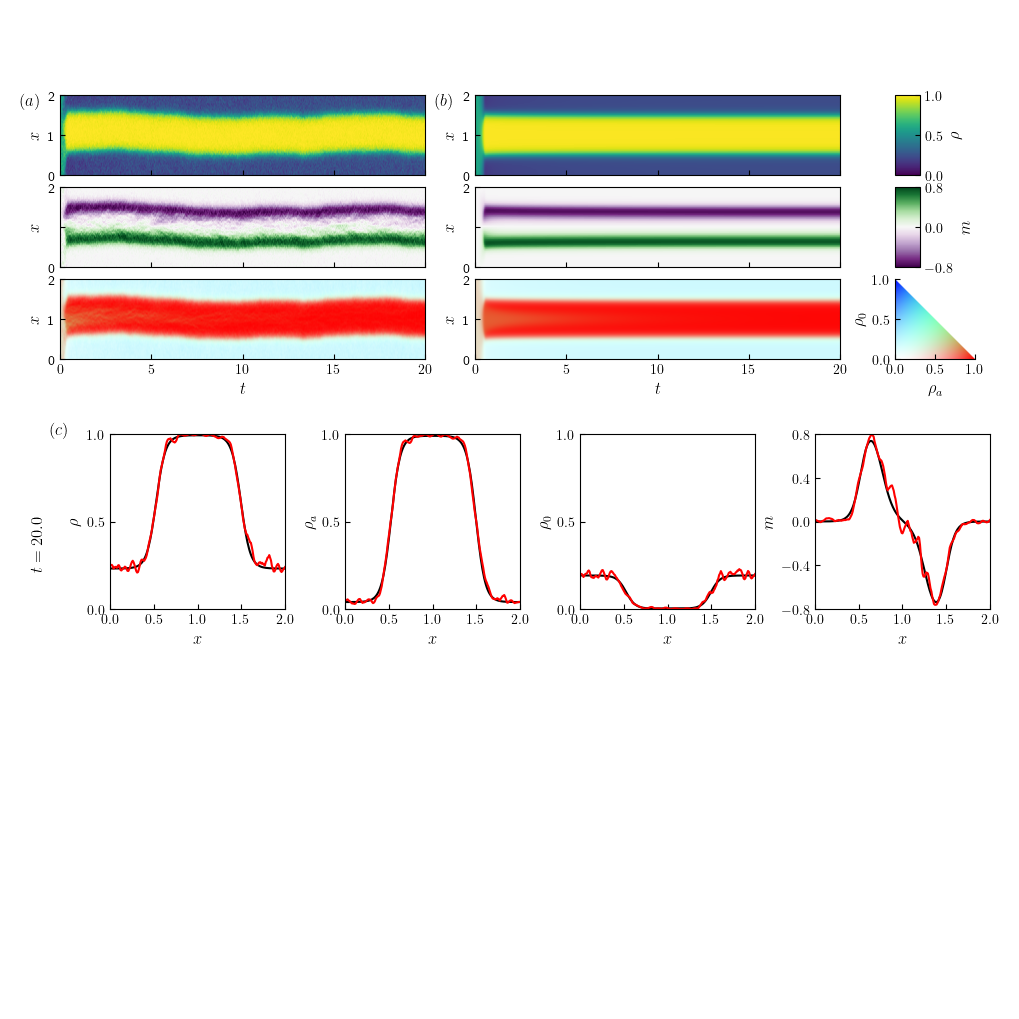

In [5]:
param = params[1]
fig2 = create_figure(param);

# Figure 3

/Users/bruna/Documents/People/Mason_James/Nonreciprocal_APLG/data/pm_sims_pro/figs_2-3/[DT,v0,DR,N,Lx,Ly,ϕa,ϕp]=[1.0, 20.0, 1.0, 100.0, 2.0, 0.5, 0.3, 0.6]/T=20.0_Δt=0.01.jld2
/Users/bruna/Documents/People/Mason_James/Nonreciprocal_APLG/data/pm_sims_pro/figs_2-3/[DT,v0,DR,N,Lx,Ly,ϕa,ϕp]=[1.0, 20.0, 1.0, 100.0, 2.0, 0.5, 0.3, 0.6]/T=19.99_Δt=0.01.jld2
fast load sim
/Users/bruna/Documents/People/Mason_James/Nonreciprocal_APLG/data/pm_pdes_pro/figs_2-3/[DT,v0,DR,Δx,Lx,ϕa,ϕp]=[1.0, 20.0, 1.0, 0.01, 2.0, 0.3, 0.6]/T=20.0_Δt=0.01.jld2
/Users/bruna/Documents/People/Mason_James/Nonreciprocal_APLG/data/pm_pdes_pro/figs_2-3/[DT,v0,DR,Δx,Lx,ϕa,ϕp]=[1.0, 20.0, 1.0, 0.01, 2.0, 0.3, 0.6]/T=19.99_Δt=0.01.jld2
/Users/bruna/Documents/People/Mason_James/Nonreciprocal_APLG/data/pm_pdes_pro/figs_2-3/[DT,v0,DR,Δx,Lx,ϕa,ϕp]=[1.0, 20.0, 1.0, 0.01, 2.0, 0.3, 0.6]/T=19.99_Δt=0.01.jld2
fast load pde (fallback)


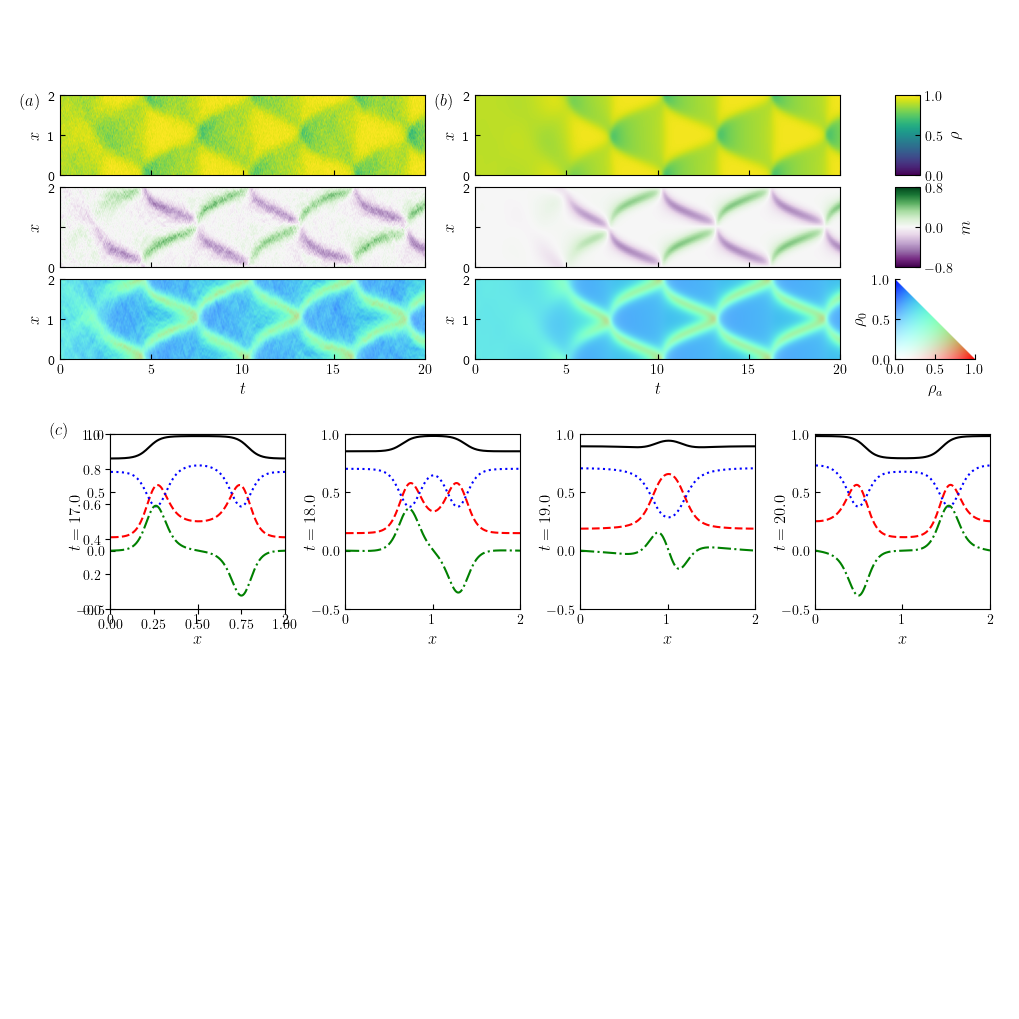

In [6]:
param = params[2]
fig3 = create_figure_evol(param);
